##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Variational Autoencoder

本部分内容参考TensorFlow官方文档翻译编写。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Charmve/computer-vision-in-action/blob/main/notebooks/16_CVAE.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

该 notebook 演示了如何训练变分自动编码器（VAE）（[1](https://arxiv.org/abs/1312.6114) ，[2](https://arxiv.org/abs/1401.4082)）。 在MNIST数据集上。 VAE是自动编码器的一种概率形式，该模型采用高维输入数据将其压缩为较小的表示形式。 与传统的自动编码器将输入映射到潜在矢量不同，VAE将输入数据映射到概率分布的参数中，例如高斯的均值和方差。 这种方法产生连续的，结构化的潜在空间，这对于图像生成很有用。 

![CVAE image latent space](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cvae_latent_space.jpg?raw=1)

## 安装依赖

In [2]:
!pip install -q tensorflow-probability

# to generate gifs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

## 加载MNIST数据集
每个MNIST图像最初都是784个整数的矢量，每个整数在0-255之间，代表像素的强度。 我们在模型中使用伯努利分布对每个像素建模，并对数据集进行静态二值化。

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

## 使用 *tf.data* 批处理和随机整理数据

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## 使用 *tf.keras.Sequential* 定义编码器和解码器网络

在我们的VAE示例中，我们将两个小型ConvNet用于编码器和解码器网络。 在文献中，这些网络也分别称为推理/识别和生成模型。 我们使用 ``tf.keras.Sequential`` 来简化实现。 在下面的描述中，令 $x$ 和 $z$ 分别表示观测值和潜在变量。 

准备工作做完了后，这里正式开始编写实现VAE模型。

### (1) 重参数化技巧 (Reparameterization Trick)

训练过程中，为了生成样本 $z$ 以便于 decoder 操作，我们可以从 encoder 生成的分布中进行采样。但是，由于反向传播无法通过随机节点，因此此采样操作会产生瓶颈。

为了解决这个问题，我们使用了一个重新参数化的技巧。我们使用 decoder 参数和另一个参数 $\varepsilon$ 近似z，如下所示：

$$ z = \mu +\sigma \ \odot \ \varepsilon $$
<p align="right"> 式（12）</p>

其中 $\mu$ 和 $\sigma$ 表示高斯分布中的 **均值** 和 **标准差**。它们可以从 decoder 输出中导出。可以认为 $\varepsilon$ 是用来保持 $z$ 随机性的随机噪声。我们从标准正态分布生成。

现在的 $z$ 是 $q(z|x)$ 生成（通过参数 $\mu$，$\sigma$ 和 $\varepsilon$），这将使模型分别通过 $\mu$, $\sigma$ 在 encoder 中 反向传播梯度，同时通过 $\varepsilon$ 保持 $z$ 的随机性。


### (2) 网络结构 (Network architecture)

对于 VAE 模型构建，

- 在 Encoder NN中，使用两个卷积层和一个完全连接的层。、
- 在 Decoder NN中，通过使用一个完全连接的层和三个卷积转置层来镜像这种结构。
注意，在训练VAE时，通常避免使用批次标准化，因为使用小批量的额外随机性可能会加剧抽样随机性之外的不稳定性。



In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 定义损失函数和优化器


如上所述，VAE 通过 $\log p(x)$ 极大似然 ELBO ( the evidence lower bound) 进行训练：
$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

<p align="right"> 式（13）</p>

实际操作中，我们优化了这种单样本蒙特卡罗估计：
$$\log p(x| z) + \log p(z) - \log q(z|x),$$

<p align="right"> 式（14）</p>

其中 $z$ 从 $q(z|x)$ 中采样。

**Note**: 我们也可以分析计算KL项，但是为了简单起见，这里我们将所有三个项合并到Monte Carlo估计器中。

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 训练

* 我们从迭代数据集开始。
* 在每次迭代期间，我们将图像传递给编码器，以获得近似后验 q ( z ∣ x ) q(z|x)q(z∣x) 的一组均值和对数方差参数(log-variance parameters）。
* 然后，我们应用 重参数化技巧 从 q ( z ∣ x ) q(z|x)q(z∣x) 中采样。
* 最后，我们将重新参数化的样本传递给解码器，以获取生成分布 p ( x ∣ z ) p(x|z)p(x∣z) 的 logit。

* **注意**：由于我们使用的是由 keras 加载的数据集，其中训练集中有 6 万个数据点，测试集中有 1 万个数据点，因此我们在测试集上的最终 ELBO 略高于对 Larochelle 版 MNIST 使用动态二值化的文献中的报告结果。

### 生成图片

* 进行训练后，可以生成一些图片了。
* 我们首先从单位高斯先验分布 p ( z ) p(z)p(z) 中采样一组潜在向量。
* 随后生成器将潜在样本 z zz 转换为观测值的 logit，得到分布 p ( x ∣ z ) p(x|z)p(x∣z)。
* 这里我们画出伯努利分布的概率。


In [10]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -156.7376708984375, time elapse for current epoch: 4.276784658432007


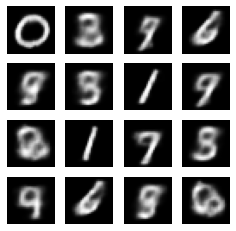

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

### 一百次循环后，生成的图片如下

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

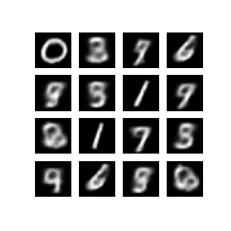

In [15]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [16]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


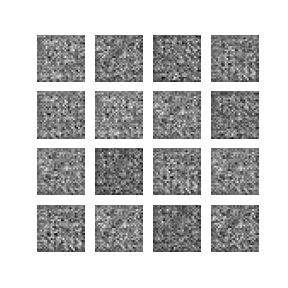

In [17]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### 显示来自 latent space 的 2D 数字流形

运行下面的代码将显示不同数字类别的连续分布，每个数字在2D潜在空间中会变形为另一个数字。 我们使用 [TensorFlow Probability](https://www.tensorflow.org/probability) 为潜在空间生成标准正态分布。

In [18]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

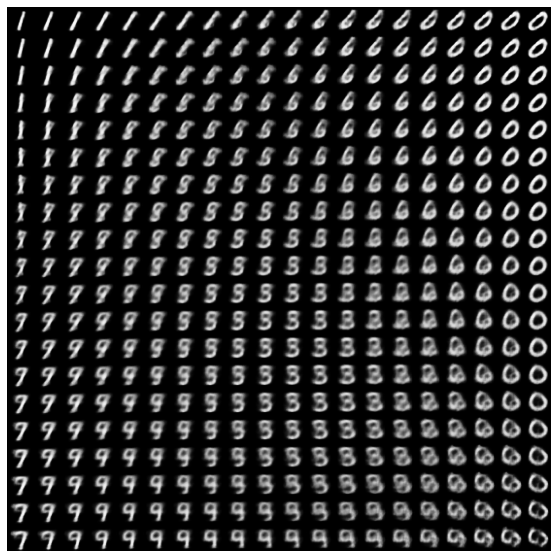

In [19]:
plot_latent_images(model, 20)

## 下一步工作

本教程演示了如何使用TensorFlow实现卷积变分自动编码器。

下一步，您可以尝试通过增加网络规模来改善模型输出。
- 例如，您可以尝试将“ Conv2D”和“ Conv2DTranspose”各层的“ filter”参数设置为512。

请注意，为了生成最终的2D潜像图，您需要将“ latent_dim”保持为2。此外，随着网络规模的增加，训练时间也会增加。

您也可以尝试使用其他数据集（例如CIFAR-10）实施VAE。

VAE可以以几种不同的样式以及不同的复杂性来实现。 您可以在以下资源中找到其他实现：

- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

如果您想了解有关VAE的更多信息，请参阅[变式自动编码器简介](https://arxiv.org/abs/1906.02691) 论文原文或本书内容 [12.4 变分自编码器 Variational Auto-encoder, VAE](https://github.com/Charmve/computer-vision-in-action/blob/main/docs/3_%E8%BF%9B%E9%98%B6%E7%AF%87/chapter12-生成对抗模型/chapter12_4-变分自编码器VAE.md).